# 특화 모델1(강북구, 도봉구, 성동구, 양천구, 용산구, 종로구, 중랑구)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import shap

In [2]:
df = pd.read_csv("data/seoul_preprocessed.csv")
print(df.shape)

(44090, 31)


In [3]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(index=test_df.index)

In [4]:
# test를 제외한 데이터로 risk level 추출
df_nonzero = train_df[train_df['tow_count'] > 0]

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반

# 각 구간 끝값 (경계)
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값

print(f"가운데 구간 끝값: {mid_end_value}\n")


train_df['risk_level'] = train_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)


# 결과 확인
print(train_df[['tow_count', 'risk_level']].tail())

가운데 구간 끝값: 2

       tow_count  risk_level
44085          0           0
44086          0           0
44087          0           0
44088          0           0
44089          0           0


In [5]:
# 지역 기반 분할
selected_gu = ["강북구", "도봉구", "성동구", "양천구", "용산구", "종로구", "중랑구"]
train_df = train_df[train_df["SIG_KOR_NM"].isin(selected_gu)]

In [6]:
features = train_df.columns[3:-2]
target = 'risk_level'
del train_df['tow_count']
del test_df['tow_count']

# 테스트 데이터 준비
train = train_df.iloc[:,3:]
X_test, y_test   = test_df[features], test_df[target]

In [7]:
exp_clf = setup(data = train, target = target, session_id=42)

In [8]:
best_model = compare_models()

In [9]:
xgb = create_model('xgboost', class_weight='balanced')

In [11]:
tuned_xgb = tune_model(xgb, optimize='F1')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [14]:
final_model = finalize_model(tuned_xgb)
prediction = predict_model(final_model, data = X_test)

In [ ]:
prediction

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

In [ ]:
# 혼동 행렬 
cm = confusion_matrix(y_test, prediction['prediction_label'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

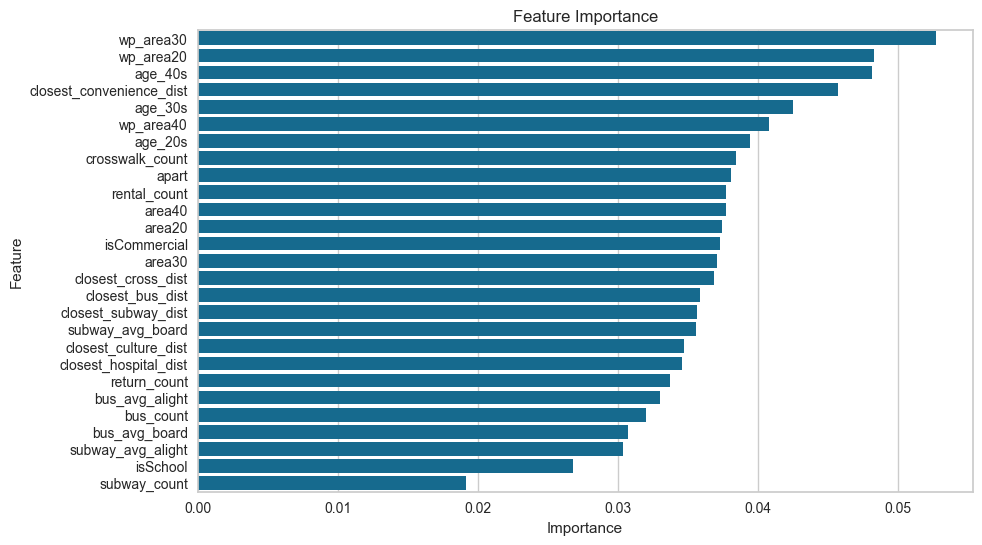

In [65]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

클래스 0


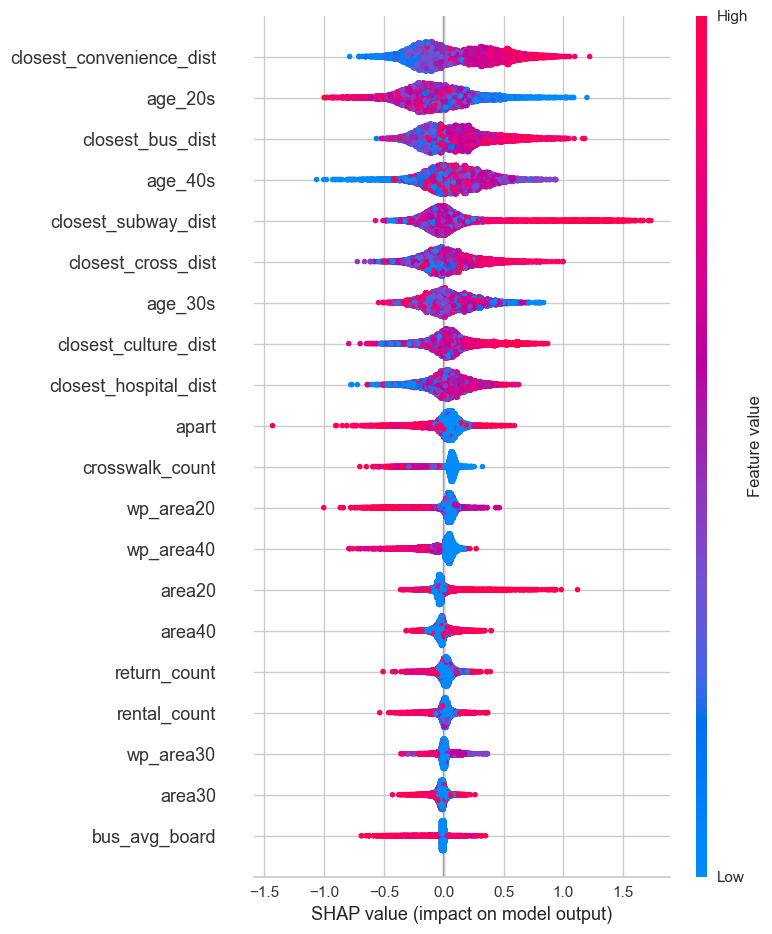

클래스 1


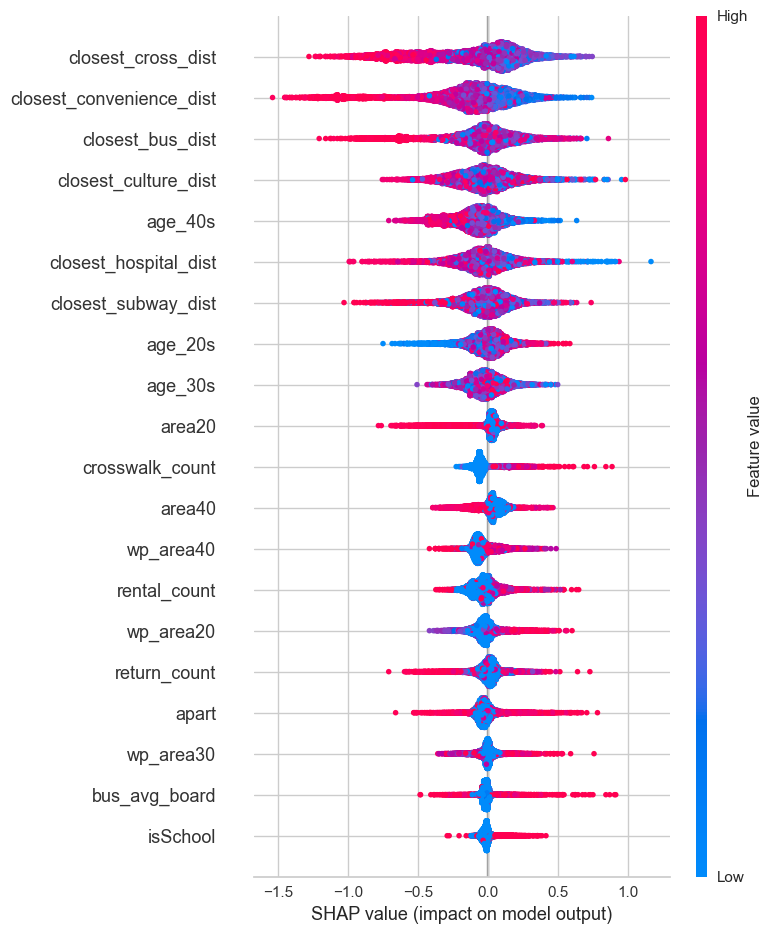

클래스 2


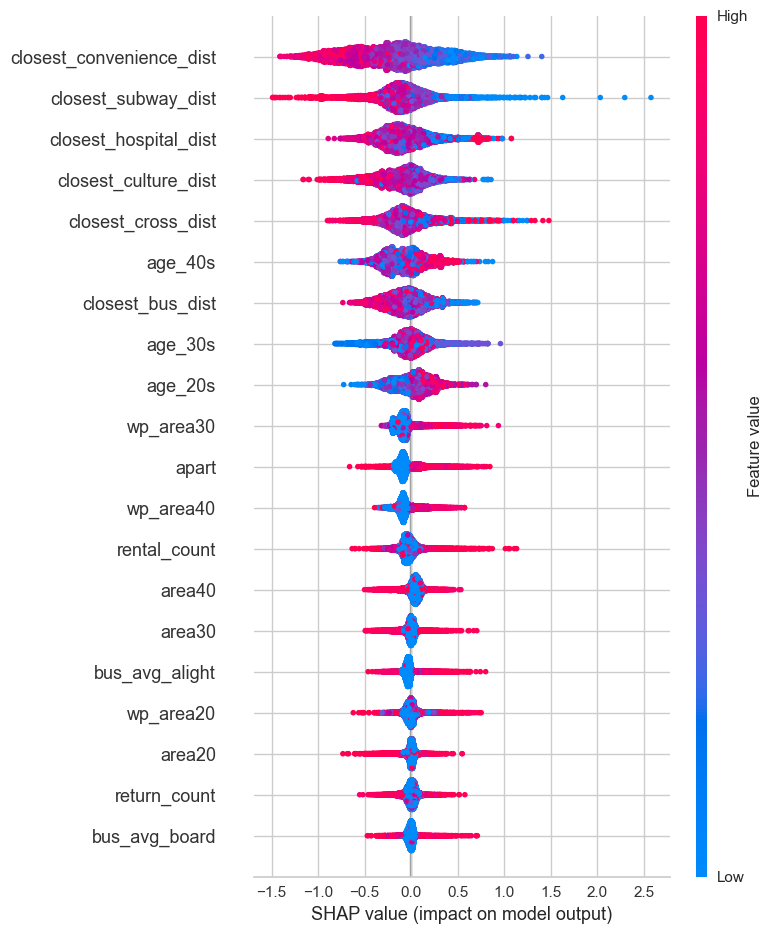

In [66]:
X_test_transformed = final_model[:-1].transform(X_test)

explainer = shap.Explainer(final_model.steps[-1][1])
shap_values = explainer(X_test_transformed)

for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test_transformed)

In [ ]:
# 모델 저장
save_model(final_model, 'models/domain_specific_model_1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['isSchool', 'rental_count',
                                              'return_count', 'apart',
                                              'closest_hospital_dist',
                                              'closest_convenience_dist',
                                              'closest_culture_dist', 'age_20s',
                                              'age_30s', 'age_40s',
                                              'crosswalk_count',
                                              'closest_cross_dist', 'bus_count',
                                              'closest_bus_dist', 'subway_count',
                                              'clos...
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
            